In [0]:
https://datawhatnow.com/pseudo-labeling-semi-supervised-learning/

1. Load Data (ground truth, 5000 rows of unlabeled data)
2. Pre-process data - make ground truth and test data of same format
3. PCA
4. Algorithms - train (Pseudo labeling and label prop).
5. Evaluate f1 and AUC.

In [0]:
# imports
import io
import numpy as np
import pandas as pd
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
import seaborn as sn
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale


from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import files
uploaded = files.upload()

Saving unlabeled_with_dummies.xlsx to unlabeled_with_dummies.xlsx


In [0]:
df_test = pd.read_excel('unlabeled_with_dummies.xlsx', encoding='latin-1')
df_test.head()

,Unnamed: 0,AgeGroup,Query Text,Result,Specialty,vomiting,fever,mottled skin,headache,word finding difficulties,breathing problem,migraine,weight loss,leg cut,blurred vision,dizziness,fainting,smoker,lethargy,irritability,fatigue,swollen gums,increased heart rate,chickenpox,sweats,abdominal pain,apprehension,hypertension,swallowing problem,coughing,chest pain resting,nausea,stiff neck,malaise,sob,hemoptysis,chronic cough,coughing up blood,proteinuria,hematuria,...,non pruritic rash,positive antinuclear antibodies,sound sensitivity,unable to speak,hematochezia,tachypneic,decreased urine output,african american,low bp,bph,high lipids,unable to maintain an erection,pneumothorax,hypermobility,absent pulse,melena,renal insufficiency,family history of sudden cardiac death,anemic,vitamin d deficiency,lower abdominal discomfort,constant headache,hoarse voice,shallow breathing,jaw ache,face ache,ear pain,low rbc count,elevated monocytes,overweight,thirsty,unable to eat,irritable bowel,decreased bp,post partum,neutropenic,Sex_female,Sex_male,Pregnancy_not pregnant,Pregnancy_pregnant
0,0,7,upper back skin sensation | nauseous | gipping...,"Sarcoidosis, Heart Attack, Pyelonephritis, Lym...",General,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,1,8,nausea | vomiting | spine pain | strange sensa...,"Sarcoidosis, Heart Attack, Abdominal Aortic An...",General,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,2,9,ringing tinnitus | ear pressure | abnormal hea...,"Ear Infection, Meniere's Disease, Superior Can...",General,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,3,6,stomach pain after eating | stomach cramps | s...,"Intestinal Ischemia , Irritable Bowel Syndrome...",General,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,4,9,ringing tinnitus | ear pressure | abnormal hea...,"Meniere's Disease, Ear Infection, Superior Can...",General,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [0]:
from google.colab import files
uploaded = files.upload()

Saving labeled_with_dummies.xlsx to labeled_with_dummies.xlsx


In [0]:
df_train = pd.read_excel('labeled_with_dummies.xlsx', encoding='latin-1')
df_train.head()

,Unnamed: 0,AgeGroup,Query Text,Result,Specialty,vomiting,fever,mottled skin,headache,word finding difficulties,breathing problem,migraine,weight loss,leg cut,blurred vision,dizziness,fainting,smoker,lethargy,irritability,fatigue,swollen gums,increased heart rate,chickenpox,sweats,abdominal pain,apprehension,hypertension,swallowing problem,coughing,chest pain resting,nausea,stiff neck,malaise,sob,hemoptysis,chronic cough,coughing up blood,proteinuria,hematuria,...,non pruritic rash,positive antinuclear antibodies,sound sensitivity,unable to speak,hematochezia,tachypneic,decreased urine output,african american,low bp,bph,high lipids,unable to maintain an erection,pneumothorax,hypermobility,absent pulse,melena,renal insufficiency,family history of sudden cardiac death,anemic,vitamin d deficiency,lower abdominal discomfort,constant headache,hoarse voice,shallow breathing,jaw ache,face ache,ear pain,low rbc count,elevated monocytes,overweight,thirsty,unable to eat,irritable bowel,decreased bp,post partum,neutropenic,Sex_female,Sex_male,Pregnancy_not pregnant,Pregnancy_pregnant
0,0,4,severe leg pain|vomiting|fever|mottled skin,Sepsis and Shock,INFECT,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,8,headache|word finding difficulties|parietial a...,Brain Neoplasms,NEOPL,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,2,7,breathing problem|migraine|weight loss|arm and...,Lung Neoplasms,NEOPL,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,3,6,leg cut|intense pain|vomiting,Necrotising Fasciitis,INFECT,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,4,8,headache|blurred vision,Giant Cell Arteritis,RHEUM,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [0]:
df_train.Specialty.value_counts()

INFECT      127
NEURO        77
RHEUM        48
NEOPL        47
GASTRO       43
RESP         28
ENDO         25
CARDIO       24
DERM         23
ORTHO        17
PSYCH        16
VASC         13
HEMAT        11
METAB        10
SHOCK         8
OBGYN         7
HEPATO        7
UROL          6
ALLERG        5
OPHTHAL       4
NEPHRO        4
EAR           3
RESP          2
TOXIC         2
TRAUMA        1
IMMUN         1
GENE          1
SOCIAL        1
CARDIO        1
Name: Specialty, dtype: int64

##Generate Pseudo Labels

In [0]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [0]:
def create_augmented_train(X, y, model, test, features, target, sample_rate):
    '''
    Create and return the augmented_train set that consists
    of pseudo-labeled and labeled data.
    '''
    num_of_samples = int(len(test) * sample_rate)

    # Train the model and generate pseudo-labels
    model.fit(X, y)
    pseudo_labeles = model.predict(test[features])

    # Add these pseudo-labels to the test set
    augmented_test = test.copy(deep=True)
    augmented_test[target] = pseudo_labeles

    # Take a subset of the test set with pseudo-labeles and append in onto
    # the training set
    sampled_test = augmented_test.sample(n=num_of_samples)
    temp_train = pd.concat([X, y], axis=1)
    augemented_train = pd.concat([sampled_test, temp_train], ignore_index = True)
    
    # Shuffle the augmented dataset and return it
    return (augemented_train)


In [0]:

X_test = df_test.drop(columns = ['Unnamed: 0', 'Query Text', 'Result', 'Specialty'])
X_train = df_train.drop(columns = ['Unnamed: 0', 'Query Text', 'Result', 'Specialty'])
Y_train = df_train['Specialty']

features = X_train.columns
#features
# #concat

# X = pd.concat([X1, X2])
# #Y = pd.concat([])
# X.head()

In [0]:
Y_train.shape

(562,)

In [0]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

clf_r = RidgeClassifier(class_weight='balanced')
rf = RandomForestClassifier()
xgb = XGBRegressor()

target = 'Specialty'

df_pseudo = create_augmented_train(X_train, Y_train, clf_r, df_test, features, target, 0.8)

In [0]:
df_pseudo = df_pseudo.drop(columns=['Unnamed: 0', 'Query Text', 'Result'])

In [0]:
df_pseudo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4561 entries, 0 to 4560
Columns: 829 entries, AgeGroup to Pregnancy_pregnant
dtypes: int64(828), object(1)
memory usage: 28.8+ MB


In [0]:
df_pseudo.sample(10)

,AgeGroup,Specialty,vomiting,fever,mottled skin,headache,word finding difficulties,breathing problem,migraine,weight loss,leg cut,blurred vision,dizziness,fainting,smoker,lethargy,irritability,fatigue,swollen gums,increased heart rate,chickenpox,sweats,abdominal pain,apprehension,hypertension,swallowing problem,coughing,chest pain resting,nausea,stiff neck,malaise,sob,hemoptysis,chronic cough,coughing up blood,proteinuria,hematuria,sore throat,flank pain,foot pain,...,non pruritic rash,positive antinuclear antibodies,sound sensitivity,unable to speak,hematochezia,tachypneic,decreased urine output,african american,low bp,bph,high lipids,unable to maintain an erection,pneumothorax,hypermobility,absent pulse,melena,renal insufficiency,family history of sudden cardiac death,anemic,vitamin d deficiency,lower abdominal discomfort,constant headache,hoarse voice,shallow breathing,jaw ache,face ache,ear pain,low rbc count,elevated monocytes,overweight,thirsty,unable to eat,irritable bowel,decreased bp,post partum,neutropenic,Sex_female,Sex_male,Pregnancy_not pregnant,Pregnancy_pregnant
4385,3,GASTRO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2110,3,PSYCH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4199,3,INFECT,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3477,5,TRAUMA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1869,7,GASTRO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1337,8,INFECT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1526,7,TRAUMA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1534,6,TRAUMA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1817,5,SHOCK,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1016,9,HEMAT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [0]:
#df_pseudo.to_excel('final_df.xlsx')

In [0]:
df_pseudo.Specialty.value_counts()

TRAUMA      982
IMMUN       532
INFECT      529
NEOPL       330
GASTRO      317
RHEUM       191
NEPHRO      190
NEURO       183
PSYCH       165
UROL        148
ENDO        137
SHOCK       125
RESP        120
CARDIO      112
EAR         103
ORTHO        71
VASC         61
DERM         51
HEMAT        43
OBGYN        38
METAB        34
HEPATO       22
RESP         18
ALLERG       17
TOXIC        15
GENE         10
CARDIO        8
OPHTHAL       7
SOCIAL        2
Name: Specialty, dtype: int64

In [0]:
#Replace NaN's in the new Y column with the corresponding value in 'Speciality' Column

#df_pseudo[df_pseudo.Specialty != 'General']

#df_pseudo['Y'] = df_pseudo.apply(lambda x : x['Specialty'] if x['Specialty'] != 'General' else x == x['Y'] , axis=1)

#df_pseudo.loc[df_pseudo.Specialty != 'General', 'Y'] = df_pseudo['Y']
# for row in df_pseudo.Specialty:
#   if row != 'General':
#     df_pseudo['Y'] == row

# for index, row in df_pseudo.iterrows():
#   if row['Y'] == NaN :
#     print(row['Specialty'])
    #df_pseudo.at[index, 'Y'] == row['Specialty']

In [0]:
#df_pseudo["Y"][94]

In [0]:
3#df_pseudo.head()




3

##Build Classifier


In [0]:
df_pseudo.head()

,AgeGroup,Specialty,vomiting,fever,mottled skin,headache,word finding difficulties,breathing problem,migraine,weight loss,leg cut,blurred vision,dizziness,fainting,smoker,lethargy,irritability,fatigue,swollen gums,increased heart rate,chickenpox,sweats,abdominal pain,apprehension,hypertension,swallowing problem,coughing,chest pain resting,nausea,stiff neck,malaise,sob,hemoptysis,chronic cough,coughing up blood,proteinuria,hematuria,sore throat,flank pain,foot pain,...,non pruritic rash,positive antinuclear antibodies,sound sensitivity,unable to speak,hematochezia,tachypneic,decreased urine output,african american,low bp,bph,high lipids,unable to maintain an erection,pneumothorax,hypermobility,absent pulse,melena,renal insufficiency,family history of sudden cardiac death,anemic,vitamin d deficiency,lower abdominal discomfort,constant headache,hoarse voice,shallow breathing,jaw ache,face ache,ear pain,low rbc count,elevated monocytes,overweight,thirsty,unable to eat,irritable bowel,decreased bp,post partum,neutropenic,Sex_female,Sex_male,Pregnancy_not pregnant,Pregnancy_pregnant
0,6,NEPHRO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,8,TRAUMA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,7,CARDIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,9,IMMUN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,9,SHOCK,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [0]:
#df_pseudo = df_pseudo.drop(df_pseudo[df_pseudo.Specialty in ['TRAUMA' ]].index, inplace=True)

df_pseudo.loc[(df_pseudo.Specialty == 'CARDIO  '),'Specialty']='CARDIO'
df_pseudo.loc[(df_pseudo.Specialty == 'RESP '),'Specialty']='RESP'

In [0]:
len(df_pseudo.Specialty.unique())

27

In [0]:
A = df_pseudo.drop(columns=['Specialty'])
b = df_pseudo['Specialty']

#A_train, A_test, b_train, b_test = train_test_split(A, b, test_size = 0.1, stratify=b, random_state = 73)

A_train, A_test, b_train, b_test = train_test_split(A, b)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_rf.fit(A_train, b_train)

pred_rf = clf_rf.predict(A_test)

print(metrics.classification_report(b_test, pred_rf))
#score

              precision    recall  f1-score   support

      ALLERG       0.00      0.00      0.00         4
      CARDIO       0.00      0.00      0.00        25
        DERM       0.00      0.00      0.00        11
         EAR       0.00      0.00      0.00        28
        ENDO       0.00      0.00      0.00        32
      GASTRO       0.00      0.00      0.00        86
        GENE       0.00      0.00      0.00         3
       HEMAT       0.00      0.00      0.00        12
      HEPATO       0.00      0.00      0.00         8
       IMMUN       0.00      0.00      0.00       132
      INFECT       0.69      0.33      0.45       125
       METAB       0.00      0.00      0.00        10
       NEOPL       0.00      0.00      0.00        90
      NEPHRO       0.00      0.00      0.00        43
       NEURO       0.00      0.00      0.00        34
       OBGYN       0.00      0.00      0.00        12
     OPHTHAL       0.00      0.00      0.00         1
       ORTHO       0.00    

In [0]:
from sklearn.linear_model import RidgeClassifier

clf_r = RidgeClassifier()
clf_r.fit(A_train, b_train)
score = clf_r.score(A_test, b_test)

pred_ridge = clf_r.predict(A_test)

#print(score)
#print(metrics.confusion_matrix(b_test, pred))

print(metrics.classification_report(b_test, pred_ridge))

              precision    recall  f1-score   support

      ALLERG       0.00      0.00      0.00         4
      CARDIO       0.80      0.32      0.46        25
        DERM       0.64      0.82      0.72        11
         EAR       1.00      0.96      0.98        28
        ENDO       0.85      0.53      0.65        32
      GASTRO       0.89      0.66      0.76        86
        GENE       0.75      1.00      0.86         3
       HEMAT       0.71      0.42      0.53        12
      HEPATO       1.00      0.50      0.67         8
       IMMUN       0.64      1.00      0.78       132
      INFECT       0.84      0.68      0.75       125
       METAB       0.86      0.60      0.71        10
       NEOPL       0.78      0.60      0.68        90
      NEPHRO       0.81      0.58      0.68        43
       NEURO       0.59      0.29      0.39        34
       OBGYN       1.00      0.83      0.91        12
     OPHTHAL       0.00      0.00      0.00         1
       ORTHO       1.00    

In [0]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf_knn = KNN()
clf_knn.fit(A_train, b_train)
score = clf_knn.score(A_test, b_test)

pred_knn = clf_knn.predict(A_test)
#print(score)

print(metrics.classification_report(b_test, pred_knn))

              precision    recall  f1-score   support

      ALLERG       0.00      0.00      0.00         4
      CARDIO       0.40      0.16      0.23        25
        DERM       0.50      0.09      0.15        11
         EAR       1.00      0.04      0.07        28
        ENDO       0.75      0.09      0.17        32
      GASTRO       0.58      0.33      0.42        86
        GENE       0.00      0.00      0.00         3
       HEMAT       1.00      0.25      0.40        12
      HEPATO       0.00      0.00      0.00         8
       IMMUN       0.42      1.00      0.59       132
      INFECT       0.68      0.38      0.49       125
       METAB       1.00      0.20      0.33        10
       NEOPL       0.74      0.16      0.26        90
      NEPHRO       0.44      0.56      0.49        43
       NEURO       0.30      0.09      0.14        34
       OBGYN       1.00      0.17      0.29        12
     OPHTHAL       0.00      0.00      0.00         1
       ORTHO       1.00    

In [0]:
# from sklearn.naive_bayes import MultinomialNB

# clf_nb = MultinomialNB()
# clf_nb.fit(A_train, b_train)

# pred_nb = clf_nb.predict(A_test)

# score = clf_nb.score(A_test, b_test)

# print(metrics.classification_report(b_test, pred_nb))

##Implement PCA to optimize

In [0]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(A_train)

# Apply transform to both the training set and the test set.
A_train = scaler.transform(A_train)
A_test = scaler.transform(A_test)

In [0]:
# Make an instance of the Model
pca = PCA(.95)

model_pca = pca.fit(A_train)


In [0]:
pca.n_components_

490

In [0]:

##X1 = pca.transform(X1)
#X2 = pca.transform(X2)

Text(0.5, 1.0, 'Explained Variance Plot')

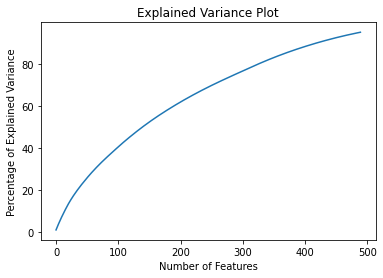

In [0]:

#model = PCA(n_components=A_train.shape[1] - 1)
#model.fit(A_train)

cumulative_variance = np.round(np.cumsum(model_pca.explained_variance_ratio_)*100, decimals=4)
plt.plot(cumulative_variance)
plt.xlabel('Number of Features')
plt.ylabel('Percentage of Explained Variance')
plt.title('Explained Variance Plot')




In [0]:
A_train = model_pca.transform(A_train)
A_test = model_pca.transform(A_test)

In [0]:
A_train.shape

(3420, 497)

In [0]:
clf_r_new = RidgeClassifier()
clf_r_new.fit(A_train, b_train)
score_new = clf_r_new.score(A_test, b_test)

pred_ridge_new = clf_r_new.predict(A_test)

#print(score)
#print(metrics.confusion_matrix(b_test, pred))

print(metrics.classification_report(b_test, pred_ridge_new))

              precision    recall  f1-score   support

      ALLERG       1.00      1.00      1.00         1
      CARDIO       0.62      0.29      0.39        28
        DERM       0.50      0.33      0.40        12
         EAR       0.92      0.96      0.94        24
        ENDO       0.89      0.65      0.75        48
      GASTRO       0.79      0.60      0.68        73
        GENE       0.50      0.50      0.50         2
       HEMAT       0.60      0.38      0.46         8
      HEPATO       0.40      0.67      0.50         3
       IMMUN       0.67      0.98      0.80       148
      INFECT       0.82      0.69      0.75       129
       METAB       0.50      0.71      0.59         7
       NEOPL       0.68      0.49      0.57        78
      NEPHRO       0.79      0.47      0.59        40
       NEURO       0.83      0.30      0.44        50
       OBGYN       0.60      0.43      0.50         7
     OPHTHAL       1.00      0.67      0.80         3
       ORTHO       0.73    

In [0]:
clf_rf_new = RandomForestClassifier(max_depth=2, random_state=0)
clf_rf_new.fit(A_train, b_train)
score = clf_rf_new.score(A_test, b_test)

pred_rf_new = clf_rf_new.predict(A_test)

print(metrics.classification_report(b_test, pred_rf_new))

              precision    recall  f1-score   support

      ALLERG       0.00      0.00      0.00         1
      CARDIO       0.00      0.00      0.00        28
        DERM       0.00      0.00      0.00        12
         EAR       0.00      0.00      0.00        24
        ENDO       0.00      0.00      0.00        48
      GASTRO       0.00      0.00      0.00        73
        GENE       0.00      0.00      0.00         2
       HEMAT       0.00      0.00      0.00         8
      HEPATO       0.00      0.00      0.00         3
       IMMUN       0.52      0.99      0.68       148
      INFECT       0.29      0.57      0.39       129
       METAB       0.00      0.00      0.00         7
       NEOPL       0.00      0.00      0.00        78
      NEPHRO       0.00      0.00      0.00        40
       NEURO       0.00      0.00      0.00        50
       OBGYN       0.00      0.00      0.00         7
     OPHTHAL       0.00      0.00      0.00         3
       ORTHO       0.00    

In [0]:
clf_knn_new = KNN()
clf_knn_new.fit(A_train, b_train)
#score_ = clf_knn.score(A_test, b_test)

pred_knn_new = clf_knn_new.predict(A_test)
#print(score)

print(metrics.classification_report(b_test, pred_knn_new))

              precision    recall  f1-score   support

      ALLERG       0.50      1.00      0.67         1
      CARDIO       0.33      0.39      0.36        28
        DERM       0.33      0.33      0.33        12
         EAR       0.67      0.67      0.67        24
        ENDO       0.56      0.48      0.52        48
      GASTRO       0.69      0.52      0.59        73
        GENE       0.50      1.00      0.67         2
       HEMAT       0.40      0.25      0.31         8
      HEPATO       0.25      0.33      0.29         3
       IMMUN       0.69      0.93      0.79       148
      INFECT       0.55      0.40      0.46       129
       METAB       0.55      0.86      0.67         7
       NEOPL       0.57      0.60      0.58        78
      NEPHRO       0.66      0.47      0.55        40
       NEURO       0.59      0.40      0.48        50
       OBGYN       0.43      0.43      0.43         7
     OPHTHAL       0.00      0.00      0.00         3
       ORTHO       0.70    